<a href="https://colab.research.google.com/github/Shrutijatain/Shrutijatain/blob/main/minor_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import ipywidgets as widgets
from IPython.display import display, Audio

# Download and unzip ESC-50 dataset
!wget https://github.com/karoldvl/ESC-50/archive/master.zip -O /content/ESC-50-master.zip
!unzip /content/ESC-50-master.zip -d /content/ESC-50-master

# Load ESC-50 metadata
metadata = pd.read_csv('/content/ESC-50-master/ESC-50-master/meta/esc50.csv')

# Define target and non-target classes
scream_class = "crying_baby"  # Substitute scream with "crying_baby"
non_scream_classes = ["dog", "engine", "rain"]  # Non-alert sounds

metadata.head()


--2025-01-07 18:48:48--  https://github.com/karoldvl/ESC-50/archive/master.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/karolpiczak/ESC-50/archive/master.zip [following]
--2025-01-07 18:48:48--  https://github.com/karolpiczak/ESC-50/archive/master.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master [following]
--2025-01-07 18:48:48--  https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.113.10
Connecting to codeload.github.com (codeload.github.com)|140.82.113.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/content/ESC-50-master.zip’

/content/ESC

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [ ]:
# Filter data for relevant classes
filtered_data = metadata[metadata['category'].isin([scream_class] + non_scream_classes)]
print("Filtered dataset size:", filtered_data.shape[0])

Filtered dataset size: 160


In [ ]:
def extract_features(row):
    file_path = os.path.join('/content/ESC-50-master/ESC-50-master/audio', row['filename'])
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return np.mean(mfccs.T, axis=0)

# Apply feature extraction and store features in the DataFrame
filtered_data['features'] = filtered_data.apply(extract_features, axis=1)
print("Features extracted successfully.")

# Check the number of samples per class
scream_data = filtered_data[filtered_data['category'] == scream_class]
non_scream_data = filtered_data[filtered_data['category'].isin(non_scream_classes)]

print("Number of crying baby samples:", len(scream_data))
print("Number of non-alert samples:", len(non_scream_data))

# Balance dataset by taking an equal number of samples for each class
min_class_count = min(len(scream_data), len(non_scream_data))
balanced_data = pd.concat([
    scream_data.sample(min_class_count, random_state=42),
    non_scream_data.sample(min_class_count, random_state=42)
])


Features extracted successfully.
Number of crying baby samples: 40
Number of non-alert samples: 120


<ipython-input-4-fc9389dfaeb0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['features'] = filtered_data.apply(extract_features, axis=1)


In [ ]:
# Prepare features and labels
X = np.stack(balanced_data['features'].values)
y = balanced_data['category'].apply(lambda x: 1 if x == scream_class else 0).values

# Split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train the SVM classifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

model = SVC(kernel='linear', probability=True)
model.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [ ]:
# Evaluate model performance
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.80      1.00      0.89         8

    accuracy                           0.88        16
   macro avg       0.90      0.88      0.87        16
weighted avg       0.90      0.88      0.87        16

Confusion Matrix:
 [[6 2]
 [0 8]]


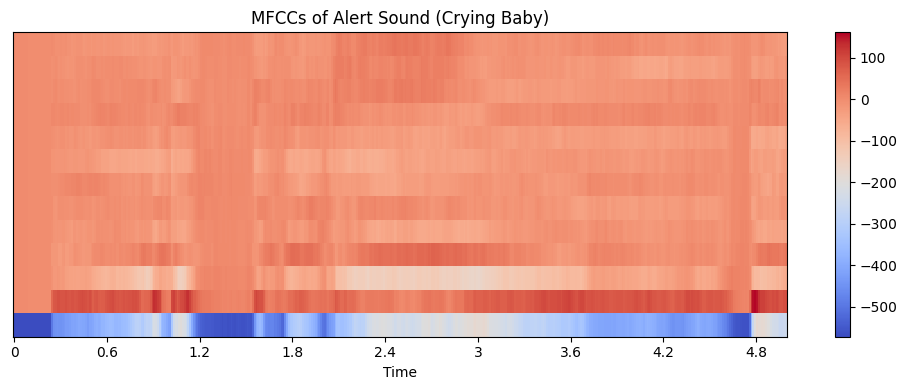

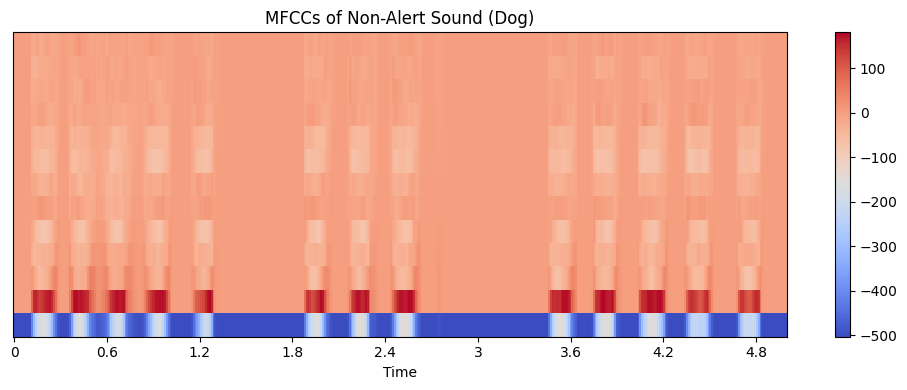

In [ ]:
# Function to plot MFCCs
def plot_mfcc(file_path, title):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, x_axis='time', sr=sr)
    plt.colorbar()
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Select random alert and non-alert samples
alert_sample = filtered_data[filtered_data['category'] == scream_class].sample(1, random_state=42)
non_alert_sample = filtered_data[filtered_data['category'] == non_scream_classes[0]].sample(1, random_state=42)

# Update file paths based on the correct audio folder location
alert_file_path = os.path.join('/content/ESC-50-master/ESC-50-master/audio', alert_sample.iloc[0]['filename'])
non_alert_file_path = os.path.join('/content/ESC-50-master/ESC-50-master/audio', non_alert_sample.iloc[0]['filename'])

# Plot MFCCs for an alert sound (e.g., "crying baby")
plot_mfcc(alert_file_path, title="MFCCs of Alert Sound (Crying Baby)")

# Plot MFCCs for a non-alert sound (e.g., "dog")
plot_mfcc(non_alert_file_path, title="MFCCs of Non-Alert Sound (Dog)")


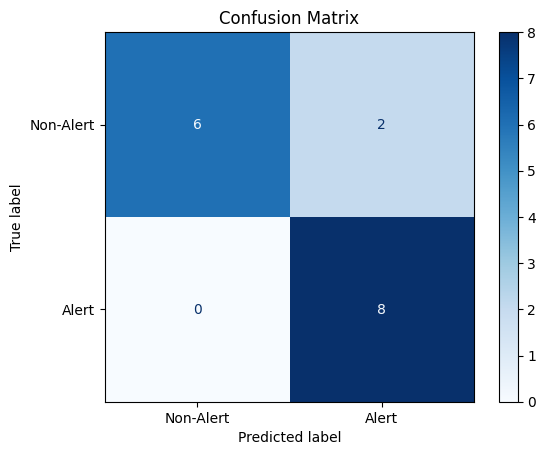

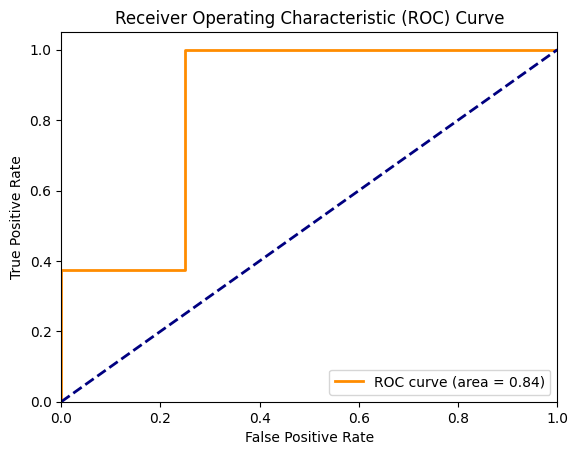

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

# Plot the confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=["Non-Alert", "Alert"], cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Plot ROC curve
y_prob = model.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

gui

In [ ]:
import ipywidgets as widgets
from IPython.display import display, Audio, clear_output
import librosa.display
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from google.colab import files

# Dark theme styling with refined colors
dark_bg = '#2b2d42'
neon_blue = '#00f9ff'
neon_green = '#39ff14'
neon_pink = '#ff007f'
text_color = '#e0e0e0'
neon_black = '#000000'

# GUI title styling
title = widgets.HTML(
    "<h2 style='color:{}; text-align:center; margin: 20px 0px; font-size:32px; font-weight: bold;'>Scream Detection System</h2>".format(neon_blue),
    layout=widgets.Layout(justify_content="center", width='100%')
)

# File upload and prediction elements with styling
file_upload = widgets.FileUpload(accept=".wav", multiple=False)
predict_button = widgets.Button(
    description="Predict",
    button_style="",
    layout=widgets.Layout(width='180px', height='50px'),
    style={'button_color': neon_black, 'font_weight': 'bold', 'font_size': '18px'}
)
play_button = widgets.Button(
    description="Play Sound",
    button_style="",
    layout=widgets.Layout(width='180px', height='50px'),
    style={'button_color': neon_black, 'font_weight': 'bold', 'font_size': '18px'}
)

output_box = widgets.Output(layout=widgets.Layout(padding="10px", width="100%", overflow='auto'))

# Layout settings for widgets
file_upload.layout.width = '60%'
output_box.layout.height = 'auto'

# Global variable to hold the uploaded file path
uploaded_file_path = None

# Function to extract features from uploaded audio
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return np.mean(mfccs.T, axis=0).reshape(1, -1)

# Function to predict sound (alert or non-alert)
def predict_sound(file_path, model):
    try:
        features = extract_features(file_path)

        # Predict using the trained model
        prediction = model.predict(features)
        prediction_proba = model.predict_proba(features)[0]

        # Determine result and border color
        result = "Alert Sound Detected" if prediction[0] == 1 else "Non-Alert Sound"
        border_color = neon_pink if prediction[0] == 1 else neon_blue

        return result, prediction_proba, border_color
    except Exception as e:
        return str(e), None, neon_black

# Function to plot MFCCs
def plot_mfcc(file_path, title):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    plt.figure(figsize=(10, 5))
    librosa.display.specshow(mfccs, x_axis='time', sr=sr)
    plt.colorbar()
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Function to play uploaded audio
def play_uploaded_audio(file_path):
    return Audio(file_path)

# Set button functionality for prediction
def on_predict_button_clicked(b):
    output_box.clear_output()

    # Check if file is uploaded
    if len(file_upload.value) > 0:
        # Get the uploaded file
        file_info = next(iter(file_upload.value.values()))
        global uploaded_file_path
        uploaded_file_path = file_info['content']

        # Save the uploaded content to a temporary file
        temp_file_path = "/content/temp_uploaded_file.wav"
        with open(temp_file_path, 'wb') as f:
            f.write(uploaded_file_path)

        file_path = temp_file_path  # Use the temporary file path for processing
    else:
        with output_box:
            clear_output(wait=True)
            print("Please upload a .wav file to predict.")
        return

    # Check if file exists
    if not os.path.isfile(file_path):
        with output_box:
            clear_output(wait=True)
            print("Error: The selected file does not exist.")
        return

    # Perform prediction using the trained model
    result, proba, border_color = predict_sound(file_path, model)

    # Display the results in output box
    with output_box:
        clear_output(wait=True)
        output_box.layout.border = f"3px solid {border_color}"

        # Highlighted and centered prediction output
        display(widgets.HTML(
            f"<div style='text-align:center; color:{neon_pink if result == 'Alert Sound Detected' else neon_blue}; font-size:26px; font-weight:bold;'>" +
            f"Prediction: {result}</div>"
        ))

        # Highlighted confidence levels
        display(widgets.HTML(
            f"<div style='text-align:center; color:{neon_green}; font-size:20px;'>Confidence - Alert: {proba[1]*100:.2f}%, Non-Alert: {proba[0]*100:.2f}%</div>"
        ))

        # Show MFCC plot
        plot_mfcc(file_path, title="MFCCs of the Uploaded Sound")

# Set button functionality for play sound
def on_play_button_clicked(b):
    if uploaded_file_path:
        # Save the uploaded content to a temporary file
        temp_file_path = "/content/temp_uploaded_file.wav"
        with open(temp_file_path, 'wb') as f:
            f.write(uploaded_file_path)

        # Play the uploaded audio
        audio = play_uploaded_audio(temp_file_path)
        display(audio)
    else:
        with output_box:
            clear_output(wait=True)
            print("Please upload a .wav file to play.")

# Attach button events
predict_button.on_click(on_predict_button_clicked)
play_button.on_click(on_play_button_clicked)

# Contact Us section with mailto email
contact_us = widgets.HTML(
    "<div style='text-align:center; color:{}; font-size:22px; margin-top:20px;'><b>Contact Us</b></div>".format(neon_blue)
)

contact_email = widgets.HTML(
    "<div style='text-align:center; color:{}; font-size:18px;'>Email: <a href='mailto:Shrutijatain@yahoo.com' style='color:{};'>Shrutijatain@yahoo.com</a></div>".format(neon_green, neon_green)
)

contact_phone = widgets.HTML(
    "<div style='text-align:center; color:{}; font-size:18px;'>Phone: +91-123-456-7890</div>".format(neon_green)
)

# Main display
app = widgets.VBox(
    [
        title,
        widgets.HTML("<hr style='border-color:{}; margin: 20px 0;'>".format(neon_blue)),
        widgets.HBox([file_upload, predict_button], layout=widgets.Layout(justify_content="center", padding="20px")),
        widgets.HBox([play_button], layout=widgets.Layout(justify_content="center", padding="20px")),
        output_box,
        contact_us,
        contact_email,
        contact_phone,
        widgets.HTML(
            "<p style='text-align:center; color:{}; font-style:italic; font-size:18px;'>Created by Shruti, Abhay, and Aditya</p>".format(neon_pink)
        )
    ],
    layout=widgets.Layout(
        width='80%',
        margin="20px auto",
        border=f'4px solid {neon_green}',
        padding="20px",
        background_color=dark_bg
    )
)

display(app)
